<a href="https://colab.research.google.com/github/ullattil/Self-Study-Notebooks/blob/master/Intro-to-ML/iml_pytorch_tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IML PyTorch Tutorial - Part 3: Datasets and a Real Example

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import time

!pip install mnist
import mnist

## Data loading, exploration and preparation

Train data shapes (2000, 28, 28) (2000,)
Test data shapes (10000, 28, 28) (10000,)


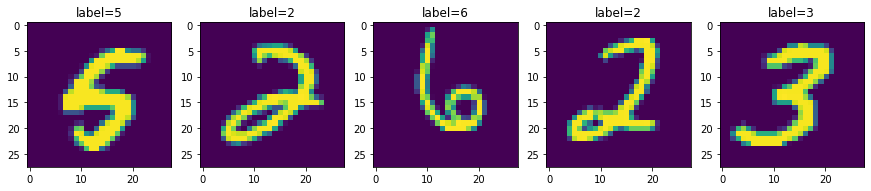

In [ ]:
# let's take fewer train points to make it harder
x_train = mnist.train_images()[:2000]
y_train = mnist.train_labels()[:2000]
x_test = mnist.test_images()
y_test = mnist.test_labels()

print('Train data shapes', x_train.shape, y_train.shape)
print('Test data shapes', x_test.shape, y_test.shape)

# plot some random train images
num_plots = 5
fig, axes = plt.subplots(ncols=num_plots, figsize=(num_plots*3, 3))
for i, rand_idx in enumerate(np.random.choice(x_train.shape[0], size=num_plots)):
  axes[i].imshow(x_train[rand_idx])
  axes[i].set_title(f'label={y_train[rand_idx]}')
fig.show()

In [ ]:
# Compute some data stats to better understand the data
print('X mean:', np.mean(x_train))
print('X std:', np.std(x_train))
print('X min:', np.min(x_train))
print('X max:', np.max(x_train))
print('X dtype', x_train.dtype, '\n')

print('Y labels', set(y_train))
print('Y dtype', y_train.dtype)

X mean: 33.1954368622449
X std: 78.4629182628044
X min: 0
X max: 255
X dtype uint8 

Y labels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Y dtype uint8


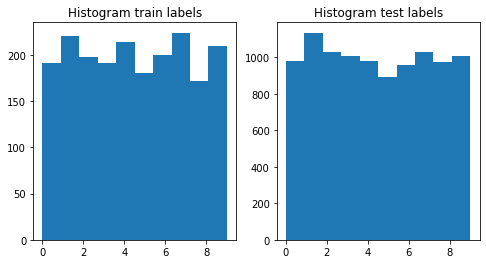

In [ ]:
# check whether classes are balanced
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].hist(y_train, bins=10)
axes[0].set_title('Histogram train labels')
axes[1].hist(y_test, bins=10)
axes[1].set_title('Histogram test labels')
plt.show()

* The image pixels are encoded as grayscale values between 0 and 255  -> we should convert them to float and standardize them.
* The labels are integers from 0 to 9. We should convert them into one-hot encodings.
* The class labels are roughly balanced. In this case, we do not not need to use special tools and metrics for imbalanced classes.

In [ ]:
# convert images and labels to tensors
# since CNNs require 3d inputs, add channel dimension of size 1
x_train_t = torch.from_numpy(x_train).float().reshape((-1, 1, 28, 28))
x_test_t = torch.from_numpy(x_test).float().reshape((-1, 1, 28, 28))

y_train_t = torch.from_numpy(y_train).long()
y_test_t = torch.from_numpy(y_test).long()

In [ ]:
# compute mean and std of training images
x_std, x_mean = torch.std_mean(x_train_t)

# standardize images 
# (make sure to apply the same standardization to the train and test)
x_train_t = (x_train_t - x_mean) / (x_std + 1e-6)
x_test_t = (x_test_t - x_mean) / (x_std + 1e-6)

print('X train mean:', torch.mean(x_train_t))
print('X train std:', torch.std(x_train_t))

print('X test mean:', torch.mean(x_test_t))
print('X test std:', torch.std(x_test_t))

X train mean: tensor(2.7306e-08)
X train std: tensor(1.0000)
X test mean: tensor(0.0076)
X test std: tensor(1.0090)


In [ ]:
# convert labels to one-hot encoding
print(y_train_t.shape, y_train_t.dtype)
y_train_t = torch.nn.functional.one_hot(y_train_t, num_classes=10).float()
y_test_t = torch.nn.functional.one_hot(y_test_t, num_classes=10).float()
print(y_train_t.shape, y_train_t.dtype)

torch.Size([2000]) torch.int64
torch.Size([2000, 10]) torch.float32


We now use utility classes from PyTorch to load our dataset. These classes make working with batches and shuffling easier.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# setup dataset
train_ds = TensorDataset(x_train_t, y_train_t)
test_ds = TensorDataset(x_test_t, y_test_t)
print('Train dataset size:', len(train_ds))
print('Test dataset size:', len(test_ds))

# setup train and test loader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True)

Train dataset size: 2000
Test dataset size: 10000


To obtain batches of data, it suffices to iterate over the loader. If we also need the index, we can use python's `enumerate()`. Each iteration over the loader gives a batch of data along with the labels. Notice that the first dimension of the batch tensor corresponds to the different data points in the batch. 

X batch shape torch.Size([64, 1, 28, 28])
Y batch shape torch.Size([64, 10])


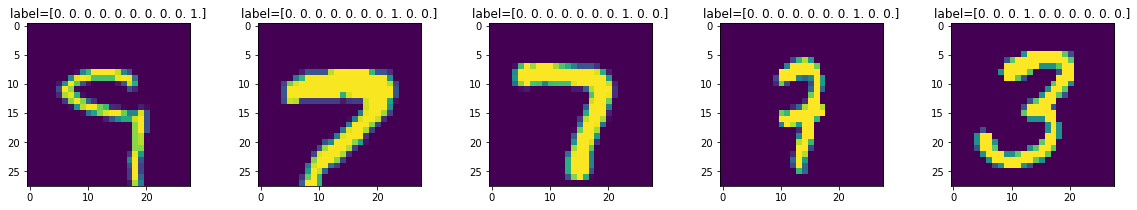

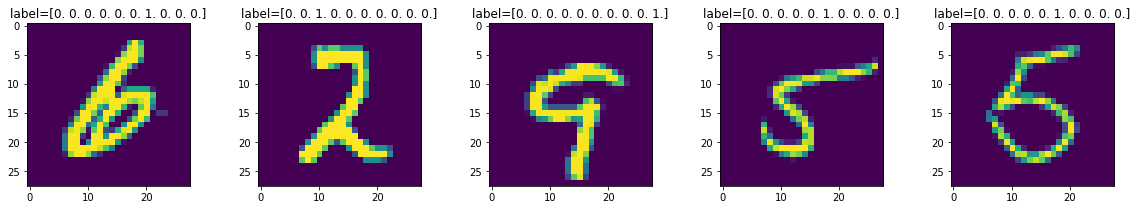

In [ ]:
# check that data loader is properly set up. We just check for the first batch
with torch.no_grad():
  for j, (x_batch, y_batch) in enumerate(train_loader):
    if j == 0:
      print('X batch shape', x_batch.shape)
      print('Y batch shape', y_batch.shape)
    num_plots = 5
    fig, axes = plt.subplots(ncols=num_plots, figsize=(num_plots*4, 3))
    for i in range(5):
      axes[i].imshow(x_batch[i].numpy().squeeze())
      axes[i].set_title(f'label={y_batch[i].numpy()}')
    fig.show()
    if j > 0:
      break

We now setup a CNN model. Observe different layers of the NN along with different parameters we set for them.

In [ ]:
class MNIST_CNN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                                     kernel_size=5, stride=1)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                                     kernel_size=3, stride=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = torch.nn.Linear(32 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # convolutional + pooling layers
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))

        # flatten all dimensions except batch
        x = self.dropout(torch.flatten(x, start_dim=1))

        # fc layers
        x = self.leaky_relu(self.dropout(self.fc1(x)))
        x = self.leaky_relu(self.dropout(self.fc2(x)))
        logits = self.fc3(x)
        return logits

# move the model to the GPU
model = MNIST_CNN().cuda()

### Define the loss funtion

The neural network outputs real-valued logits:
$$\mathrm{logit}(\mathbf{x}) = l(\mathbf{x}) = \text{NN}(\mathbf{x}) \in \mathbb{R}^{10}$$

We use the *softmax* function to turn the logits into the neural networks predicted class probabilies.
$$\hat{p}(y_c=1|\mathbf{x}) = \text{softmax}(l(\mathbf{x}))_c = \frac{\exp{ l_c(\mathbf{x})}}{\sum_{i=1}^{10} \exp{ l_i(\mathbf{x})}} ~, ~c=1, ..., 10$$

If the stack this up for all the 10 classes, we obtain
$
\hat{p}(\mathbf{y}|\mathbf{x}) = \text{softmax}(l(\mathbf{x})) \in [0,1]^{10}
$.

Since we have encoded our labels $\mathbf{y} \in \{0,1\}^{10}$ as one-hot encoding, we can write the likelihood of a data point $(\mathbf{x}_j, \mathbf{y}_j)$ under our predictive class distribution as:
$$\hat{p}(\mathbf{y}_j|\mathbf{x}_j) = \mathbf{y}_j^\top \text{softmax}(l(\mathbf{x}_j))$$
Since $\mathbf{y}_j$ has only one non-zero entry, this effectively selects the predictied probability for the class to the label corresponds to.

We use the negative log-likelihood of the data as the loss function:
$$
\mathcal{L} := - \sum_{j=1}^n \log \hat{p}(\mathbf{y}_j|\mathbf{x}_j) = - \sum_{j=1}^n\log(\mathbf{y}_j^\top \text{softmax}(l(\mathbf{x}_j))) = - \sum_{j=1}^n\log \left( \mathbf{y}_j^\top \text{softmax}(l(\mathbf{x}_j)) \right) = - \sum_{j=1}^n \mathbf{y}_j^\top  l(\mathbf{x}_j)  + \mathrm{const}.
$$

In [ ]:
# loss function that takes in logits and true labels and 
# outputs neg. log-likelihood (aka. cross-entrpy loss)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# define utility functions to compute classification accuracy and
# perform evaluation / testing

def accuracy(logits: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
  # computes the classification accuracy
  correct_label = torch.argmax(logits, axis=-1) == torch.argmax(label, axis=-1)
  assert correct_label.shape == (logits.shape[0],)
  acc = torch.mean(correct_label.float())
  assert 0. <= acc <= 1.
  return acc

def evaluate(model: torch.nn.Module) -> torch.Tensor:
  # goes through the test dataset and computes the test accuracy
  model.eval()  # bring the model into eval mode
  with torch.no_grad():
    acc_cum = 0.0
    num_eval_samples = 0
    for x_batch_test, y_label_test in test_loader:
      x_batch_test, y_label_test = x_batch_test.cuda(), y_label_test.cuda()
      batch_size = x_batch_test.shape[0]
      num_eval_samples += batch_size
      acc_cum += accuracy(model(x_batch_test), y_label_test) * batch_size
    avg_acc = acc_cum / num_eval_samples
    assert 0 <= avg_acc <= 1
    return avg_acc

## Perform training and testing

In [ ]:
# Setup the optimizer (adaptive learning rate method)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
  # reset statistics trackers
  train_loss_cum = 0.0
  acc_cum = 0.0
  num_samples_epoch = 0
  t = time.time()

  # Go once through the training dataset (-> epoch)
  for x_batch, y_batch in train_loader:
      # zero grads and put model into train mode
      optim.zero_grad()
      model.train()
      
      # move data to GPU
      x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

      # forward pass
      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)

      # backward pass and gradient step
      loss.backward()
      optim.step()

      # keep track of train stats
      num_samples_batch = x_batch.shape[0]
      num_samples_epoch += num_samples_batch
      train_loss_cum += loss * num_samples_batch
      acc_cum += accuracy(logits, y_batch) * num_samples_batch
  
  # average the accumulated statistics
  avg_train_loss = train_loss_cum / num_samples_epoch
  avg_acc = acc_cum / num_samples_epoch
  test_acc = evaluate(model)
  epoch_duration = time.time() - t
  
  # print some infos
  print(f'Epoch {epoch} | Train loss: {train_loss_cum.item():.4f} | '
  f' Train accuracy: {avg_acc.item():.4f} | Test accuracy: {test_acc.item():.4f} |'
  f' Duration {epoch_duration:.2f} sec')

  # save checkpoint of model
  if epoch % 5 == 0 and epoch > 0:
      save_path = f'model_epoch_{epoch}.pt'
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict()},
                 save_path)
      print(f'Saved model checkpoint to {save_path}')

Epoch 0 | Train loss: 4343.3931 |  Train accuracy: 0.2090 | Test accuracy: 0.6057 | Duration 0.67 sec
Epoch 1 | Train loss: 2828.0569 |  Train accuracy: 0.5055 | Test accuracy: 0.8122 | Duration 0.37 sec
Epoch 2 | Train loss: 1925.5835 |  Train accuracy: 0.6705 | Test accuracy: 0.8774 | Duration 0.37 sec
Epoch 3 | Train loss: 1371.9868 |  Train accuracy: 0.7730 | Test accuracy: 0.9125 | Duration 0.36 sec
Epoch 4 | Train loss: 1098.1367 |  Train accuracy: 0.8205 | Test accuracy: 0.9331 | Duration 0.37 sec
Epoch 5 | Train loss: 929.4026 |  Train accuracy: 0.8530 | Test accuracy: 0.9447 | Duration 0.37 sec
Saved model checkpoint to model_epoch_5.pt
Epoch 6 | Train loss: 744.4652 |  Train accuracy: 0.8870 | Test accuracy: 0.9459 | Duration 0.37 sec
Epoch 7 | Train loss: 716.7729 |  Train accuracy: 0.8975 | Test accuracy: 0.9520 | Duration 0.40 sec
Epoch 8 | Train loss: 632.3963 |  Train accuracy: 0.9030 | Test accuracy: 0.9514 | Duration 0.37 sec
Epoch 9 | Train loss: 585.8896 |  Train acc

## Loading the model from a checkpoint



In [ ]:
# load model from checkpoint
model_loaded = MNIST_CNN()
checkpoint = torch.load('model_epoch_5.pt')
model_loaded.load_state_dict(checkpoint['model_state_dict'])

model_loaded.eval()

MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Check out some predictions of the loaded checkpoint

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


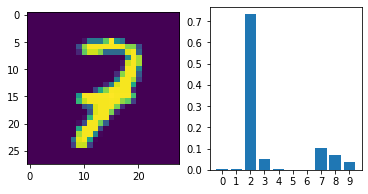

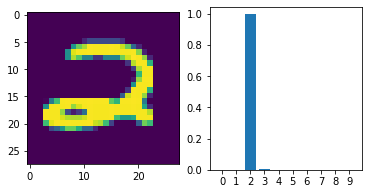

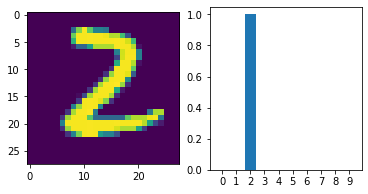

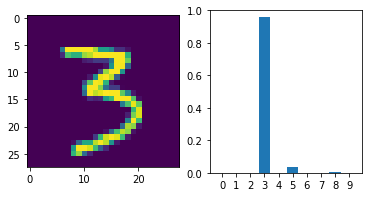

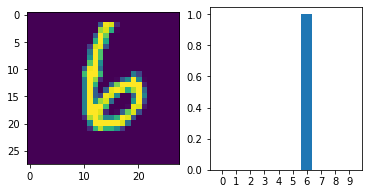

In [ ]:
with torch.no_grad():
  for j, (x_batch, y_batch) in enumerate(test_loader):
    num_plots = 5
    logits = model_loaded(x_batch)
    class_probs = torch.nn.Softmax()(logits).numpy()
    for i in range(5):
      fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
      axes[0].imshow(x_batch[i].numpy().squeeze())
      axes[1].bar(range(10), class_probs[i])
      axes[1].set_xticks(range(10))
    fig.show()
    break